# Introduction

This notebook is essentially a copy of the `brats_segmentation_3d.ipynb` notebook from https://github.com/Project-MONAI/tutorials. We will not have time for a detailed introduction to MONAI. Please consult the documentation: https://monai.io.

Our goal is to illustrate a possible approach to do brain tumor segmentation. I.e. extracting meaningful tumor regions, in this case "whole tumor", "tumor core" and "enhancing tumor". As discussed, this can give important imaging biomarkers as f.ex. volume, and also provide "region of interests" for extracting radiomics features.  

# Setup

In [1]:
%matplotlib inline
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
%config Completer.use_jedi = False

In [3]:
import os
import shutil
import tempfile

MONAI is based on PyTorch. You'll recognize some bits of this notebook from our previous discussion of PyTorch.

In [4]:
import torch

Here's the MONAI stuff we'll need:

In [5]:
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    AsChannelFirstd,
    AsDiscrete,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    ToTensord,
)
from monai.utils import set_determinism

In [6]:
from fastcore.utils import *

# Load data

In [7]:
DATA = Path('/data-ext-10tb/ubuntu/TCGA_GBMLGG-PathomicFusion')

In [8]:
path = DATA/'MONAI'
path.mkdir(exist_ok=True, parents=True)

In [9]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(np.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(
                np.logical_or(
                    np.logical_or(d[key] == 2, d[key] == 3), d[key] == 1
                )
            )
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d

In [10]:
batch_size = 4

In [11]:
train_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        RandSpatialCropd(
            keys=["image", "label"], roi_size=[128, 128, 64], random_size=False
        ),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=0.5),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=0.5),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
    ]
)

Here we load and cache the dataset (cached for more efficient training later). This takes a while... To lower system mamory requirements, set `cache_num` to a number less than 388. If you run out of GPU memory you may as usual try lowering the batch size.

In [12]:
train_ds = DecathlonDataset(
    root_dir=path,
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=True,
    num_workers=4,
    #cache_num=100,
)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)

Loading dataset:   0%|          | 0/388 [00:00<?, ?it/s]

Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
file /data-ext-10tb/ubuntu/TCGA_GBMLGG-PathomicFusion/MONAI/Task01_BrainTumour.tar exists, skip downloading.
extracted file /data-ext-10tb/ubuntu/TCGA_GBMLGG-PathomicFusion/MONAI/Task01_BrainTumour exists, skip extracting.


Loading dataset: 100%|██████████| 388/388 [03:41<00:00,  1.75it/s]


In [13]:
val_ds = DecathlonDataset(
    root_dir=path,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    num_workers=4,
)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 96/96 [00:56<00:00,  1.70it/s]


## Have a look at some data

Let's extract a sample from our training loader:

In [93]:
sample_data = next(enumerate(train_loader))

The MONAI data loaders have a specific structure:

In [94]:
sample_data[1].keys()

dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict', 'image_transforms', 'label_transforms'])

Per batch of 4 data points there are 4 images (T1, T1Gd, T2, FLAIR), each of the size (128, 128, 64) specified above:

In [95]:
sample_data[1]['image'].shape

torch.Size([4, 4, 128, 128, 64])

The same goes for the labels (i.e. the masks indicating the tumors):

In [96]:
sample_data[1]['label'].shape

torch.Size([4, 3, 128, 128, 64])

Additional image metadata is also available:

In [97]:
sample_data[1]['image_meta_dict']

{'sizeof_hdr': tensor([348, 348, 348, 348], dtype=torch.int32),
 'extents': tensor([0, 0, 0, 0], dtype=torch.int32),
 'session_error': tensor([0, 0, 0, 0], dtype=torch.int16),
 'dim_info': tensor([0, 0, 0, 0], dtype=torch.uint8),
 'dim': tensor([[  4, 240, 240, 155,   4,   1,   1,   1],
         [  4, 240, 240, 155,   4,   1,   1,   1],
         [  4, 240, 240, 155,   4,   1,   1,   1],
         [  4, 240, 240, 155,   4,   1,   1,   1]], dtype=torch.int16),
 'intent_p1': tensor([0., 0., 0., 0.]),
 'intent_p2': tensor([0., 0., 0., 0.]),
 'intent_p3': tensor([0., 0., 0., 0.]),
 'intent_code': tensor([0, 0, 0, 0], dtype=torch.int16),
 'datatype': tensor([16, 16, 16, 16], dtype=torch.int16),
 'bitpix': tensor([32, 32, 32, 32], dtype=torch.int16),
 'slice_start': tensor([0, 0, 0, 0], dtype=torch.int16),
 'pixdim': tensor([[1., 1., 1., 1., 1., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0.]]),
 'vox_

Here are a few images:

In [98]:
sample_data[1]['image'].shape

torch.Size([4, 4, 128, 128, 64])

In [99]:
# First data set in the batch:
ims = sample_data[1]['image'][0]
lbls = sample_data[1]['label'][0]

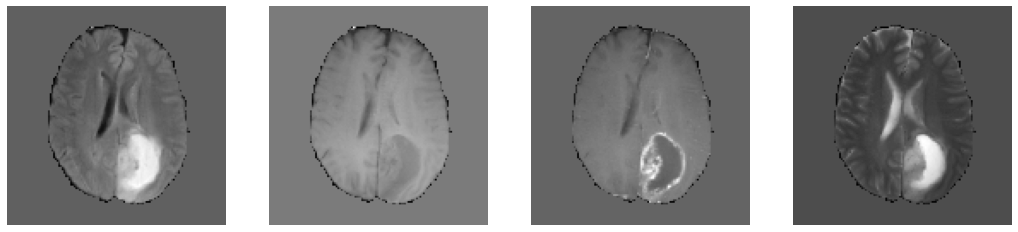

In [100]:
f, ax = plt.subplots(1,4, figsize=(18,6))
for i in range(4):
    ax[i].axis('off')
    ax[i].imshow(np.rot90(ims[i,:,:,32].detach().cpu()), cmap="gray")
plt.show()

Here are the labels overlayed on the first channel:

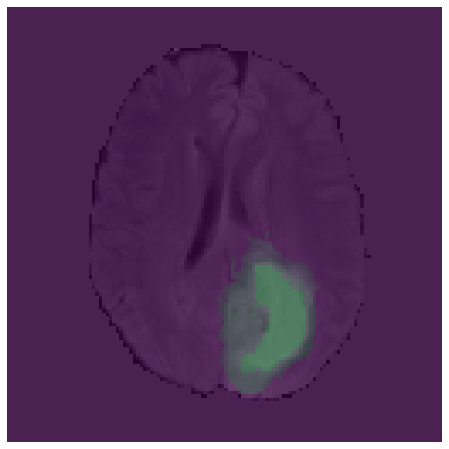

In [128]:
f = plt.figure(figsize=(8,8))

plt.imshow(np.rot90(ims[0,:,:,32].detach().cpu()), cmap="gray")

for i in range(3):
    plt.imshow(np.rot90(lbls[i,:,:,32].detach().cpu()), cmap='PRGn', alpha=0.3)

plt.axis('off')
plt.show()

# Create a model

Let's create a UNet model:

In [14]:
device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=4,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    act='MISH'
).to(device)

In [15]:
loss_function = DiceLoss(to_onehot_y=False, sigmoid=True, squared_pred=True)

We'll use the 2021 version of the Ranger optimizer https://github.com/lessw2020/Ranger21:

In [18]:
import sys
!{sys.executable} -m pip install git+https://github.com/lessw2020/Ranger21.git

  Cloning https://github.com/lessw2020/Ranger21.git to /tmp/pip-req-build-mqio5hwy
  Running command git clone -q https://github.com/lessw2020/Ranger21.git /tmp/pip-req-build-mqio5hwy


In [16]:
max_epochs = 400

In [17]:
from ranger21 import Ranger21

In [18]:
optimizer = Ranger21(model.parameters(), lr=1e-3, num_epochs=max_epochs, 
                     num_batches_per_epoch=len(train_loader),
                    use_adaptive_gradient_clipping=False)

beta_warmup_pct = 0.05154639175257732
Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On
Adaptive Gradient Clipping = False

Warm-down: Linear warmdown, starting at 65.0%, iteration 25220 of 38800
warm down will decay until 3e-05 lr


# Training loop

The following resembles the training loop from the first deep learning lecture. 

Warning: The model takes a long time to train.. 

In [19]:
root_dir = path

In [20]:
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        if step%20 == 0:
            print(
                f"{step}/{len(train_ds) // train_loader.batch_size}"
                f", train_loss: {loss.item():.4f}"
            )
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            dice_metric = DiceMetric(include_background=True, reduction="mean")
            post_trans = Compose(
                [Activations(sigmoid=True), AsDiscrete(threshold_values=True)]
            )
            metric_sum = metric_sum_tc = metric_sum_wt = metric_sum_et = 0.0
            metric_count = (
                metric_count_tc
            ) = metric_count_wt = metric_count_et = 0
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = model(val_inputs)
                val_outputs = post_trans(val_outputs)
                # compute overall mean dice
                value, not_nans = dice_metric(y_pred=val_outputs, y=val_labels)
                not_nans = not_nans.item()
                metric_count += not_nans
                metric_sum += value.item() * not_nans
                # compute mean dice for TC
                value_tc, not_nans = dice_metric(
                    y_pred=val_outputs[:, 0:1], y=val_labels[:, 0:1]
                )
                not_nans = not_nans.item()
                metric_count_tc += not_nans
                metric_sum_tc += value_tc.item() * not_nans
                # compute mean dice for WT
                value_wt, not_nans = dice_metric(
                    y_pred=val_outputs[:, 1:2], y=val_labels[:, 1:2]
                )
                not_nans = not_nans.item()
                metric_count_wt += not_nans
                metric_sum_wt += value_wt.item() * not_nans
                # compute mean dice for ET
                value_et, not_nans = dice_metric(
                    y_pred=val_outputs[:, 2:3], y=val_labels[:, 2:3]
                )
                not_nans = not_nans.item()
                metric_count_et += not_nans
                metric_sum_et += value_et.item() * not_nans

            metric = metric_sum / metric_count
            metric_values.append(metric)
            metric_tc = metric_sum_tc / metric_count_tc
            metric_values_tc.append(metric_tc)
            metric_wt = metric_sum_wt / metric_count_wt
            metric_values_wt.append(metric_wt)
            metric_et = metric_sum_et / metric_count_et
            metric_values_et.append(metric_et)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

----------
epoch 1/400
params size saved
total param groups = 1
total params in groups = 46
20/97, train_loss: 0.9372
40/97, train_loss: 0.9414
60/97, train_loss: 0.9366
80/97, train_loss: 0.9502
epoch 1 average loss: 0.9538
----------
epoch 2/400
20/97, train_loss: 0.9368
40/97, train_loss: 0.9213
60/97, train_loss: 0.9318
80/97, train_loss: 0.9723
epoch 2 average loss: 0.9427
saved new best metric model
current epoch: 2 current mean dice: 0.0663 tc: 0.0183 wt: 0.1741 et: 0.0065
best mean dice: 0.0663 at epoch: 2
----------
epoch 3/400
20/97, train_loss: 0.9663
40/97, train_loss: 0.9330
60/97, train_loss: 0.9153
80/97, train_loss: 0.9340
epoch 3 average loss: 0.9357
----------
epoch 4/400
20/97, train_loss: 0.9596
40/97, train_loss: 0.9551
60/97, train_loss: 0.9135
80/97, train_loss: 0.9358
epoch 4 average loss: 0.9311
saved new best metric model
current epoch: 4 current mean dice: 0.1018 tc: 0.0279 wt: 0.2698 et: 0.0076
best mean dice: 0.1018 at epoch: 4
----------
epoch 5/400
20/97,

In [21]:
print(
    f"train completed, best_metric: {best_metric:.4f}"
    f" at epoch: {best_metric_epoch}"
)


train completed, best_metric: 0.7627 at epoch: 370


Here are plots of the losses and metrics observed during training:

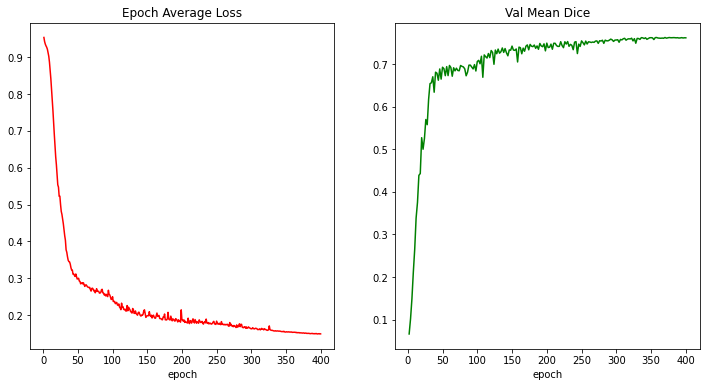

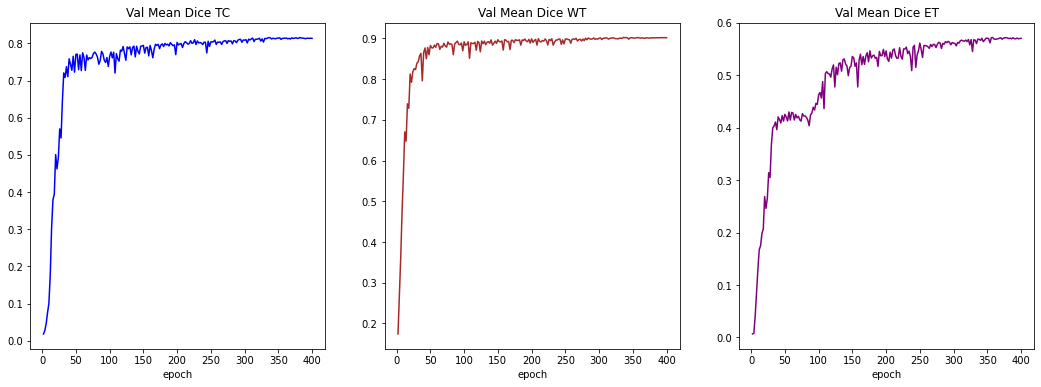

In [22]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()


Here's a set of predictions for a few random validation data instances from the top performing model:

In [ ]:
model.load_state_dict(
    torch.load(os.path.join(root_dir, "best_metric_model.pth"))
)
model.eval()

In [151]:
import random

In [148]:
def plot_preds(ds):
    with torch.no_grad():
        # select one image to evaluate and visualize the model output
        val_input = val_ds[ds]["image"].unsqueeze(0).to(device)
        val_output = post_trans(model(val_input))
        plt.figure("image", (24, 6))
        for i in range(4):
            plt.subplot(1, 4, i + 1)
            plt.title(f"image channel {i}")
            plt.imshow(val_ds[ds]["image"][i, :, :, 20].detach().cpu(), cmap="gray")
        plt.show()
        # visualize the 3 channels label corresponding to this image
        plt.figure("label", (18, 6))
        for i in range(3):
            plt.subplot(1, 3, i + 1)
            plt.title(f"label channel {i}")
            plt.imshow(val_ds[ds]["label"][i, :, :, 20].detach().cpu())
        plt.show()
        # visualize the 3 channels model output corresponding to this image
        plt.figure("output", (18, 6))
        for i in range(3):
            plt.subplot(1, 3, i + 1)
            plt.title(f"output channel {i}")
            plt.imshow(val_output[0, i, :, :, 20].detach().cpu())
        plt.show()

Example: BRATS_250.nii.gz



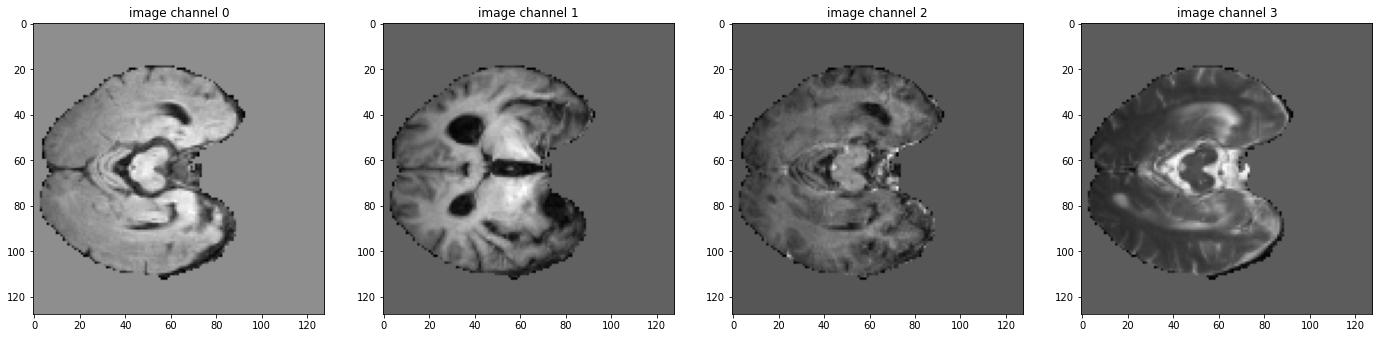

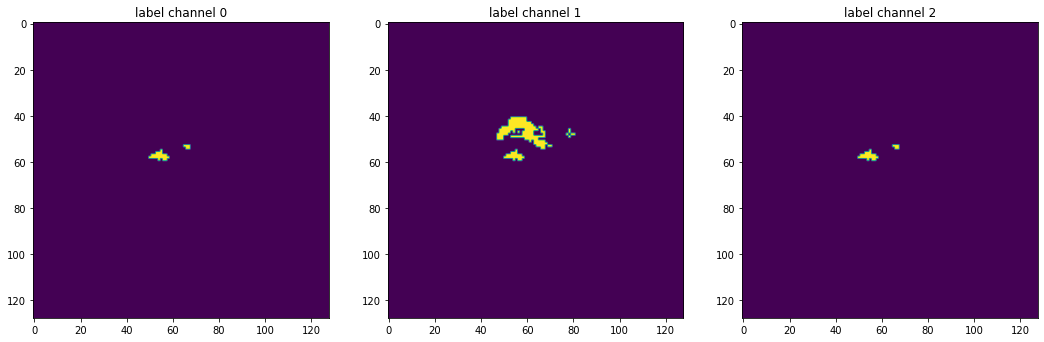

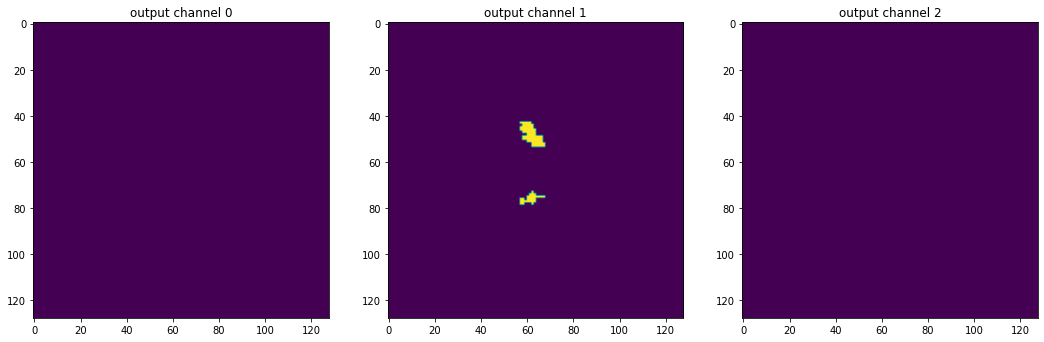

########################################
Example: BRATS_327.nii.gz



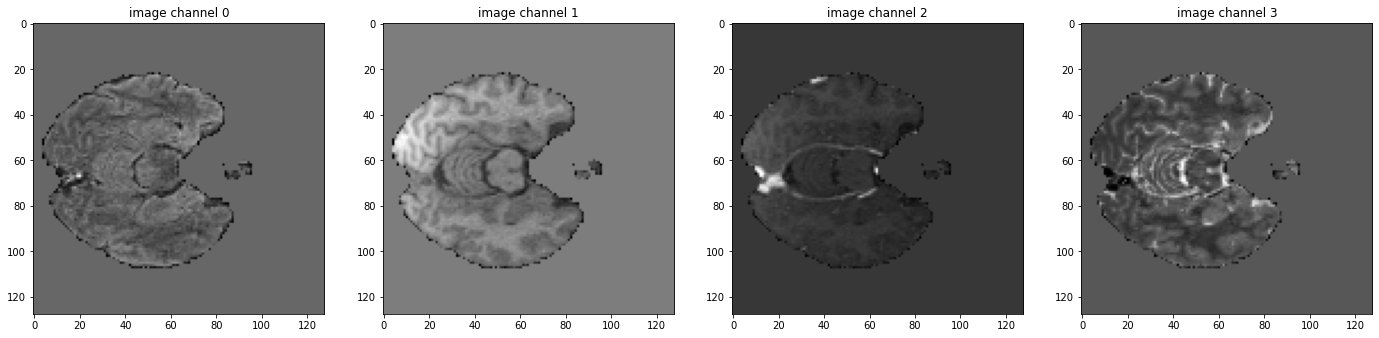

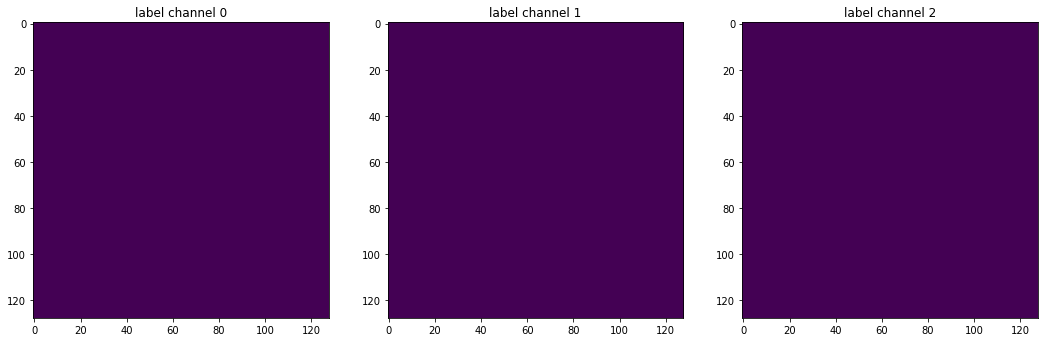

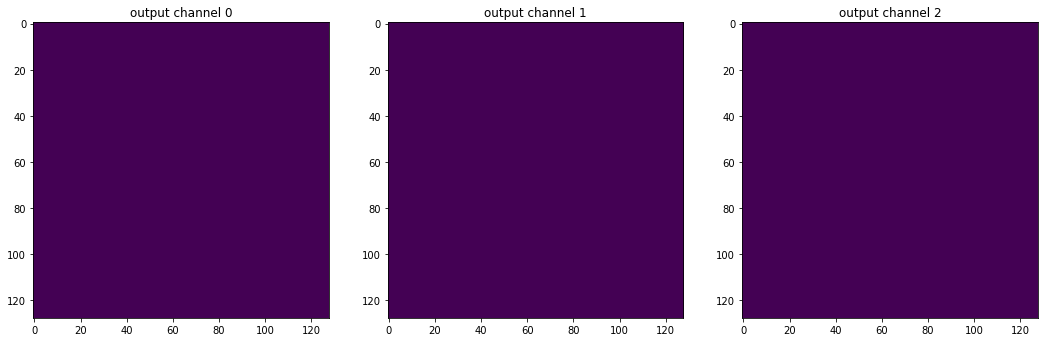

########################################
Example: BRATS_019.nii.gz



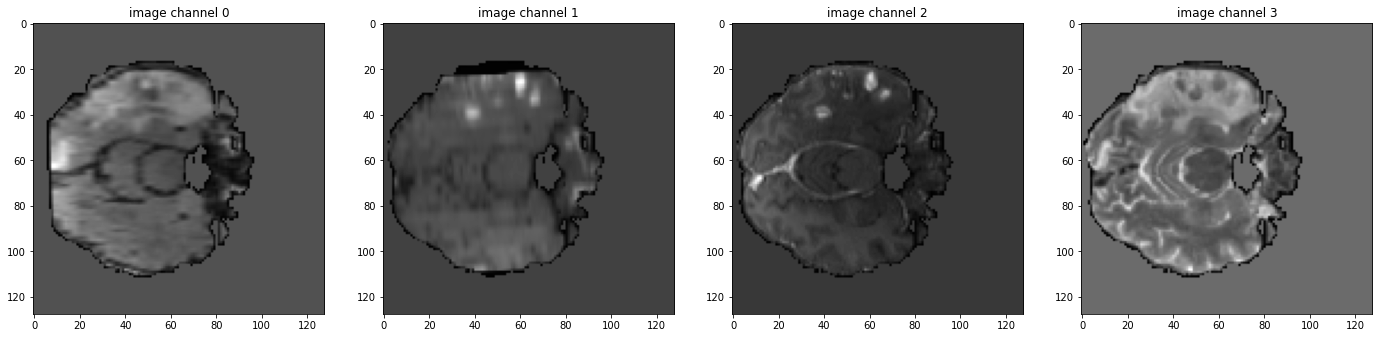

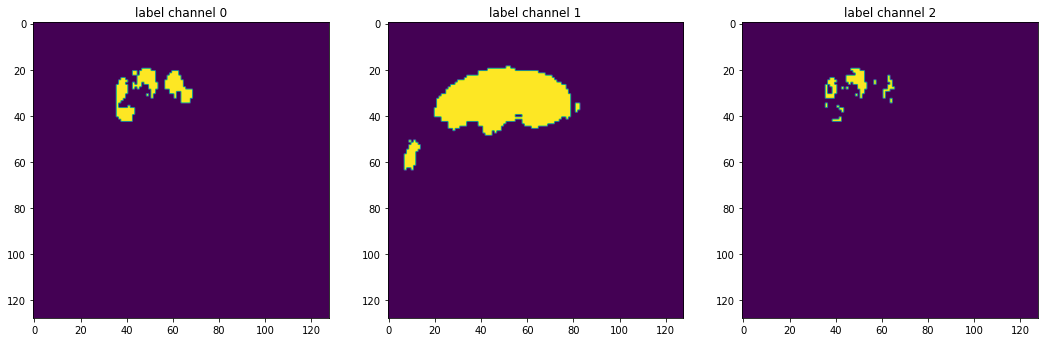

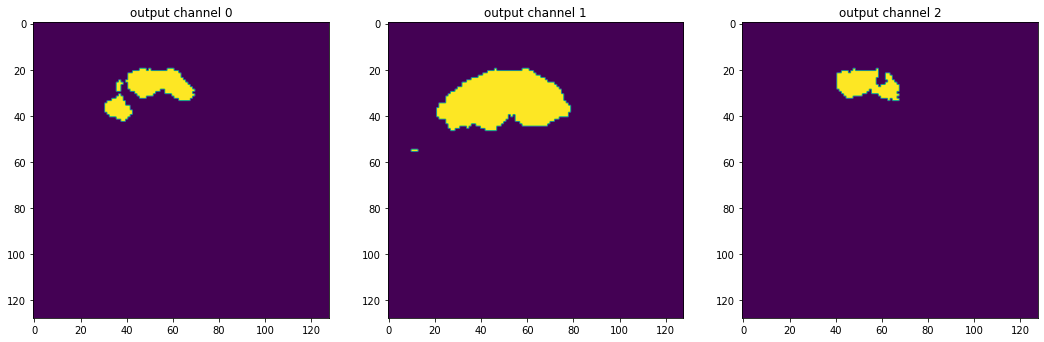

########################################
Example: BRATS_274.nii.gz



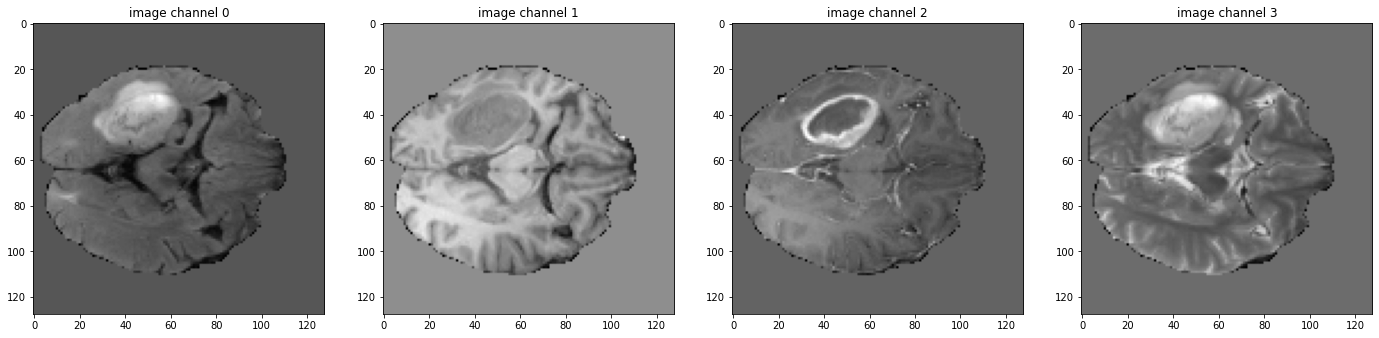

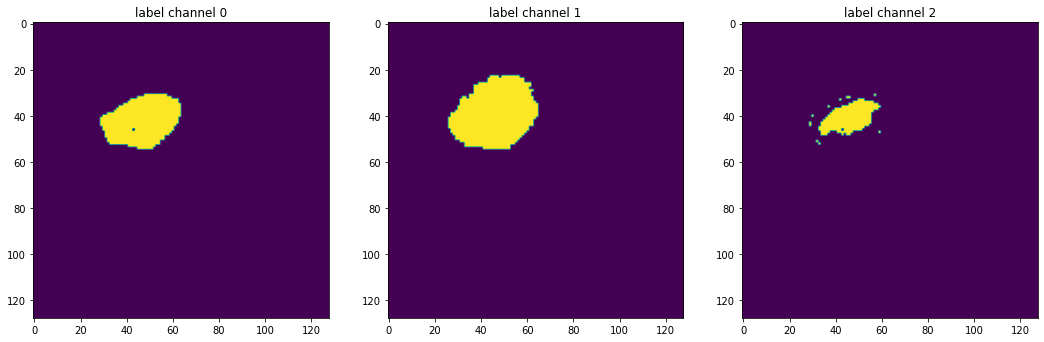

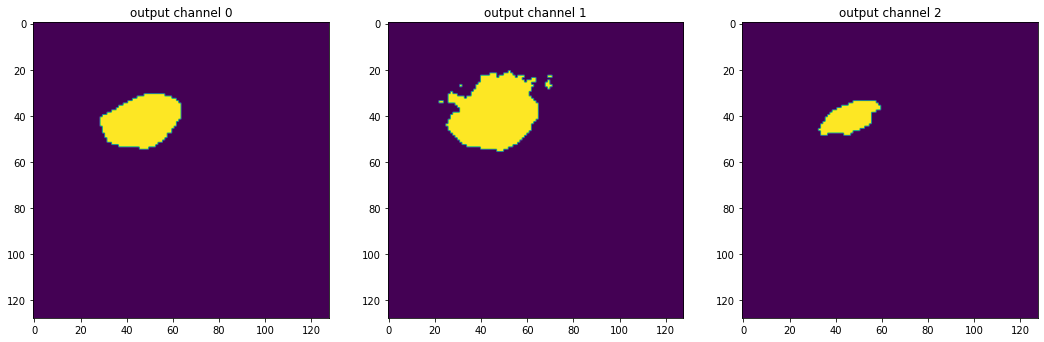

########################################


In [161]:
k=4
for ds in random.choices(range(len(val_ds)), k=k):
    fn = val_ds[ds]['image_meta_dict']['filename_or_obj'].split("/")[-1]
    print(f"Example: {fn}\n")
    plot_preds(ds)
    print("#"*40)

# Note

MONAI has a bunch of great features (https://monai.io), but some of the neat tricks we looked at in the notebooks based on fastai aren't implemented (and also other tricks). 

Which is one reason why [Sathiesh](https://skaliy.no/) is currently developing the **fastMONAI** framework combining features from fastai with MONAI:

<img src="assets/fastmonai.png">

fastMONAI was used in the following papers, and is currently used in multiple ongoing projects.
* [2D and 3D U-Nets for skull stripping in a large and heterogeneous set of head MRI using fastai](https://ojs.bibsys.no/index.php/NIK/article/view/836)_, Kaliyugarasan S, Kocinski M, Lundervold A, Lundervold AS., NIK2020, no.1, 2020.
* [Pulmonary nodule classification in lung cancer from 3D thoracic CT scans using fastai and MONAI](https://www.ijimai.org/journal/bibcite/reference/2944), S. Kaliyugarasan, A. Lundervold and A.S. Lundervold. To appear in IJIMAI, 2021.

# What's next?

Once you have extracted the tumor ROIs it's possible to quantify tumor size, shape and localization, as well as derive _radiomic_ features related to texture and the like. 

Saruar is currently doing this in a similar project, aiming to predict overall survival from tumor features derived from MRI: 

<img width=80% src="assets/saruar.png">